# Gene Dependency Auto Encoder

Evaluate the Low Rank Matrix Factorization Model with 19 learned features by training a true auto encoder with a bottle neck size of 10. In theory the auto encoder should be better because it can learn a non linear embedding. How ever it will need to learn a large number of features

One of the other uses of this notebook is to debug the deep architectures. We noticed that the validation error is often bellow the training error. This suggest a bug. see the presentation presentations/status-2020-03-13.pptx for an overview of how to debug.

ref:
- [https://www.tensorflow.org/guide/keras/train_and_evaluate](https://www.tensorflow.org/guide/keras/train_and_evaluate)
- [https://www.tensorflow.org/tutorials/keras/overfit_and_underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)

In [1]:
import logging
from   setupLogging import setupLogging
configFilePath = setupLogging( default_path='src/test/logging.test.ini.json')
logger = logging.getLogger("notebook")
logger.info("using logging configuration file:{}".format(configFilePath))

from   DEMETER2.lowRankMatrixFactorizationEasyOfUse \
            import LowRankMatrixFactorizationEasyOfUse as LrmfEoU

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam

[INFO <ipython-input-1-94f26ec5a80a>:5 - <module>()] using logging configuration file:src/test/logging.test.ini.json


In [2]:
dataDir = "data/"
dataFileName = "D2_Achilles_gene_dep_scores.tsv"
numFeatures = 19
geneFilterPercent = 0.25 
holdOutPercent = 0.40 
easyOfUse = LrmfEoU(dataDir, dataFileName, numFeatures, geneFilterPercent, holdOutPercent)

In [3]:
resultsDict = easyOfUse.loadAll()

In [4]:
# clean tidy version of demeter data
Y, R, cellLinesNames, geneNames, = resultsDict["DEMETER2"]
geneDependencies = Y
print("geneDependencies.shape:{}".format(geneDependencies.shape))

# trained model
# scipy.optimize.OptimizeResult
X, Theta, optimizeResult = resultsDict["LowRankMatrixFactorizationModel"]
genes = X
print("genes.shape:{}".format(genes.shape))
cellLines = Theta
print("cellLines.shape:{}".format(cellLines.shape))

# knockout logical filters. Use to select Y Train, Validations, and Test values
RTrain, RValidation, RTest = resultsDict["filters"]

print("number of observed values in traning set: {}".format(np.sum(RTrain)))
print ("size of traning set: {}".format(np.size(RTrain)))

geneDependencies.shape:(11193, 501)
genes.shape:(11193, 19)
cellLines.shape:(501, 19)
number of observed values in traning set: 3364160
size of traning set: 5607693


### Deep

In [5]:
import DEMETER2.AutoEncoderModelArchitectures as aema

# use tf.data Dataset instead of numpy if data does not fit into memory
# TODO: AEDWIP: add shuffle. I do not think it will make much difference
trainingData = np.multiply(geneDependencies, RTrain)
validateData = np.multiply(geneDependencies, RValidation)

In [6]:
# https://www.tensorflow.org/tutorials/keras/overfit_and_underfit#training_procedure
# Many models train better if you gradually reduce the learning rate during training.
BATCH_SIZE=1024
N_TRAIN = trainingData.shape[0]
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

adam = tf.keras.optimizers.Adam(lr_schedule)

In [7]:
# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping
# TODO: look at optional arguments
def get_callbacks(name):
  return [
    tfdocs.modeling.EpochDots(),
    tf.keras.callbacks.EarlyStopping(monitor=' val_loss'),
    tf.keras.callbacks.TensorBoard(logdir/name),
  ]

In [8]:
meaningOfLife = 42
np.random.seed(meaningOfLife)
tf.random.set_seed(meaningOfLife)


builder = aema.AutoEncoderModelArchitectures(trainingDataShape=trainingData.shape,
                                             encodingDimensions=19, 
                                             optimizer=adam, 
                                             loss='mean_squared_error',
                                             metrics=['accuracy', 'mse'])


# autoencoderModel = builder.l5Arch()
# autoencoderModel = builder.simpleArch()
autoencoderModel = builder.debugArch()

%time history = autoencoderModel.fit(\
                                    trainingData, \
                                    trainingData, \
                                    batch_size=BATCH_SIZE, \
                                    epochs=15, \
                                    callbacks=get_callbacks("AEDWIP_NAME"), \
                                    verbose=1, \
                                    validation_data=(validateData,validateData) )

# %time history = autoencoderModel.fit(\
#                                     trainingData, \
#                                     trainingData, \
#                                     epochs=15, \
#                                     verbose=1, \
#                                     validation_data=(validateData,validateData) )

NameError: name 'tfdocs' is not defined

In [9]:
autoencoderModel.count_params()

3646

In [10]:
print("hyper parameters:\n{}\n".format(builder))
autoencoderModel.summary()

hyper parameters:
traningDataShape:(11193, 501) 
numFeatures:501 
encodingDimensions:19
optimizer:<tensorflow.python.keras.optimizer_v2.adam.Adam object at 0x7fe3c6011350> 
loss:mean_squared_error 
metrics:['accuracy', 'mse']

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
e064 (Dense)                 (None, 3)                 1506      
_________________________________________________________________
bottleneck (Dense)           (None, 19)                76        
_________________________________________________________________
d064 (Dense)                 (None, 3)                 60        
_________________________________________________________________
dOut (Dense)                 (None, 501)               2004      
Total params: 3,646
Trainable params: 3,646
Non-trainable params: 0
_________________________________________________________________


In [11]:
predictedTrain = autoencoderModel.predict(trainingData)
trainingLoss = tf.keras.losses.mean_squared_error(trainingData, predictedTrain)
print("\ntotal training loss: {}".format(np.sum(trainingLoss)))

predictedVal = autoencoderModel.predict(validateData)
validationLoss =  tf.keras.losses.mean_squared_error(validateData, predictedVal)
print("\ntotal validation loss: {}".format(np.sum(validationLoss)))


total training loss: 429.5982666015625

total validation loss: 143.33135986328125


NameError: name 'history' is not defined

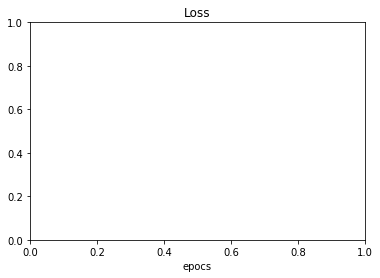

In [12]:
plt.title('Loss')
plt.xlabel('epocs')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [ ]:
# ?? https://stats.stackexchange.com/a/325602
# https://twitter.com/aureliengeron/status/1110839223878184960
plt.title('Mean Squared Error')
plt.xlabel('epocs')
plt.plot(history.history['mse'], label='train')
plt.plot(history.history['val_mse'], label='val')
plt.legend()
plt.show()

In [ ]:
plt.title('Accuracy')
plt.xlabel('epocs')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.show()

# Results

simpleArch()
```
totalLoss: 415.3407287597656

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
e064 (Dense)                 (None, 64)                32128     
_________________________________________________________________
bottleneck (Dense)           (None, 19)                1235      
_________________________________________________________________
d064 (Dense)                 (None, 64)                1280      
_________________________________________________________________
dOut (Dense)                 (None, 501)               32565     
=================================================================
Total params: 67,208
Trainable params: 67,208
Non-trainable params: 0
```

l3Arch()
```
totalLoss: 417.01519775390625

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
e128 (Dense)                 (None, 128)               64256     
_________________________________________________________________
e064 (Dense)                 (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 19)                1235      
_________________________________________________________________
d064 (Dense)                 (None, 64)                1280      
_________________________________________________________________
d128 (Dense)                 (None, 128)               8320      
_________________________________________________________________
dOut (Dense)                 (None, 501)               64629     
=================================================================
Total params: 147,976
Trainable params: 147,976
Non-trainable params: 0
_________________________
```

l5Arch()
```
totalLoss: 418.174072265625
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
e256 (Dense)                 (None, 256)               128512    
_________________________________________________________________
e128 (Dense)                 (None, 128)               32896     
_________________________________________________________________
e064 (Dense)                 (None, 64)                8256      
_________________________________________________________________
bottleneck (Dense)           (None, 19)                1235      
_________________________________________________________________
d064 (Dense)                 (None, 64)                1280      
_________________________________________________________________
d128 (Dense)                 (None, 128)               8320      
_________________________________________________________________
d256 (Dense)                 (None, 256)               33024     
_________________________________________________________________
dOut (Dense)                 (None, 501)               128757    
=================================================================
Total params: 342,280
Trainable params: 342,280
Non-trainable params: 0
```